# CO416 - Machine Learning for Imaging

## Coursework 1 - Classification

In this coursework you will be applying the material taught in the course up to and including lecture 4.

$\mathbf{NOTE - \text{READ THIS}:}$ 
- During this coursework you will be asked to comment on the performance of various aspects of the models you develop. The discussion should be done along the following lines:
    - Maximum 100 words of discussion - You are asked to be brief and on point, platitudes and excessive writing will be penalized
    - You should mention effects on accuracy, and computational requirements i.e. time and computational complexities. Empirical arguments are accepted 
    
- When you are asked to change the hyperparamenters, validate the performance of your classifier and explicitly state the optimal hyperparameters you found and their accuracy

## Question 1 (50 Points) 

In this question we will use a toy spiral dataset as generated by the [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function of sklearn

1) Create a dataset of 1000 points with a noise value of 0.1 and random_state=0 and augment it using polynomial features (recommended degree 10-15) (4 points)

In [15]:
from sklearn import datasets
from sklearn import preprocessing

# create dataset
X, y = datasets.make_moons(n_samples=1000, noise=0.1, random_state=0)

# augment the dataset
poly = preprocessing.PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)

2) Visualize your input data - the first 2 dimensions would suffice  (3 points)



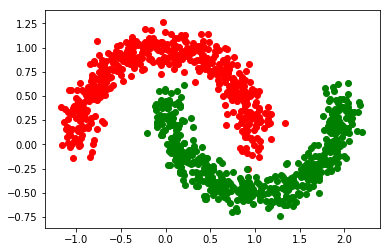

In [17]:
from matplotlib import pyplot as plt

l1_x = []
l1_y = []

l2_x = []
l2_y = []
for i, (d1, d2) in enumerate(X):
    (l1_x if y[i] == 0 else l2_x).append(d1)
    (l1_y if y[i] == 0 else l2_y).append(d2)

plt.scatter(l1_x, l1_y, c='red')
plt.scatter(l2_x, l2_y, c='green')
plt.show()

3) Use a Decision Tree to classify the data (5 points)



In [27]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np



def train_dt(X, y, criterion="gini", split=0.8):
    classifier = DecisionTreeClassifier(criterion="gini")
    split = 0.8
    split_boundary = int(split * len(y))
    train_X, train_y = X_poly[:split_boundary], y[:split_boundary]
    test_X, test_y = X_poly[split_boundary:], y[split_boundary:]
    classifier.fit(train_X, train_y)
    unique, counts = np.unique(classifier.predict(test_X) - test_y, return_counts=True)
    counts = dict(zip(unique, counts))
    accuracy = str(counts[0] / float(len(test_X)))
    return classifier, accuracy

classifier, accuracy = train_dt(X, y)

print "Accuracy: " + accuracy

Accuracy: 0.99


4) Try both Gini Impurity and Information Gain, which performs better? What is the difference between them? (4 points)

5) Perform classification using a tree depth of 1-20. Plot the accuracy versus tree depth. (5 points)



In [ ]:
## ADD YOUR CODE HERE

6) How does the depth of a tree affect performance and computational burden? (1 points)



In [ ]:
## ADD YOUR CODE HERE

7) Use Bootstrap Classifier to classify your data, base estimator should be a decision tree. Tune hyperparameters of tree depth, n_of estimators, max_samples and bootstrap. Plot accuracy versus different hyperparameters. (7 points)



In [ ]:
## ADD YOUR CODE HERE

8) Why do we use Bootstraping when we create our datasets? Did you use replacement ? Why ? (1 points) 

In [ ]:
## ADD YOUR CODE HERE

9)  Use a Decision Forest to classify the new dataset (4 points)



In [ ]:
## ADD YOUR CODE HERE

10) Modulate the number of trees to 1-99 with a step of 10. Plot accuracy versus number of trees. (4 points)



In [ ]:
## ADD YOUR CODE HERE

11) Modulate the depth of  the trees from 1 to 20 - use best number of trees from above. Plot the accuracy versus depth. (4 points)



In [ ]:
## ADD YOUR CODE HERE

12) Comment on the performance change while you modulate depth of trees and number of trees (3 points)

In [ ]:
## ADD YOUR CODE HERE

13) Visualise how the classification split is done in relation to the data both for Decision Tree and Decision Forest (3 points)

In [ ]:
## ADD YOUR CODE HERE

## Question 2 (50 Points)
In this question we will be using the fashion-MNIST dataset for image classification. 

If you are interested, you may find relevant information regarding the dataset in this paper:
Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The data is provided under `/vol/lab/course/416/data/fashion`. The dataset is already split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels and stored as 784-dimensional vector. So if you would like to visualise the images, you need to reshape the array.

There are in total 10 classes, which are labelled as follows:
0. T-shirt/top
1. Trousers
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

**Your tasks are** (all tasks carry equal marks):
- Use a Decision Forest to classify t-shirts and ankle boots - tune your forest!
- Train and compare an Adaboost classifier with a decision tree 
- Modulate the number of trees in the Adaboost and the depth of the trees. Comment on the performance and complexity 
- Train a Decsiion Forest for all classes and also compare the performance with another ensemble algorithm of your choice
- What is the theoretical difference between Random Forests and Adaboost classifiers? (100 words max)

In [ ]:
# load the data
import numpy as np
import pandas as pd

data_dir = '/vol/lab/course/416/data/fashion/'

df_train = pd.read_csv(data_dir + 'fashion_mnist_train.csv')
df_test = pd.read_csv(data_dir + 'fashion_mnist_test.csv')

x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
y_train = df_train['label'].as_matrix().astype(np.uint8)
x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
y_test = df_test['label'].as_matrix().astype(np.uint8)

In [ ]:
## ADD YOUR CODE HERE